#Configuración del entorno


1. Instalamos y verificamos las librerías que usaremos:  
   - **TensorFlow >= 2.16** (con soporte GPU)  
   - **keras‑resnet** (ResNet‑18 con pesos de ImageNet)  
   - **wandb** para el tracking de experimentos  
   - **gradio** para la demo interactiva  
   - **scikit‑image** (utilidad para métricas SSIM / PSNR)  
2. Nos autenticamos en W&B dentro del proyecto `arturo-torres-iteso/GANs`.  

In [1]:
# Verificamos versiones
import tensorflow as tf, importlib, pkg_resources, keras_resnet
print("TensorFlow:", tf.__version__)
print("keras-resnet:", pkg_resources.get_distribution("keras-resnet").version)
print("GPU disponible:", tf.config.list_physical_devices('GPU'))

# Login Weight & Biases
import wandb, os, getpass
os.environ["WANDB_PROJECT"] = "GANs"
os.environ["WANDB_ENTITY"] = "arturo-torres-iteso"
wandb.login()

<ipython-input-1-f90c5148dc89>:2: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import tensorflow as tf, importlib, pkg_resources, keras_resnet


TensorFlow: 2.18.0
keras-resnet: 0.2.0
GPU disponible: []


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: pablo-blanco (arturo-torres-iteso) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

### **¿Qué es L\*a\*b?**  
Es una forma de describir los colores de manera que se parezca más a cómo los vemos los humanos. En lugar de usar combinaciones técnicas como el RGB (rojo, verde, azul de las pantallas), L\*a\*b separa la información en tres partes fáciles de entender:  

1. **L\*** (Luminancia):  
   - Es el **"brillo"** de la imagen. Piensa en una foto en blanco y negro: el **L\*** es exactamente eso. Si L\* = 0, es negro; si L\* = 100, es blanco.  
   - *Ejemplo*: Una foto antigua en blanco y negro solo tiene información de L\*.

2. **a\*** (Eje verde-rojo):  
   - Este componente te dice si un color tiende al **verde** o al **rojo**.  
   - Valores **negativos**: más verde (como una planta).  
   - Valores **positivos**: más rojo (como una manzana).  
   - *Ejemplo*: Si a\* = +30, es un rojo intenso; si a\* = -20, es verde hierba.

3. **b\*** (Eje azul-amarillo):  
   - Este componente indica si un color tiende al **azul** o al **amarillo**.  
   - Valores **negativos**: más azul (como el cielo).  
   - Valores **positivos**: más amarillo (como el sol).  
   - *Ejemplo*: Si b\* = +40, es un amarillo vibrante; si b\* = -10, es azul claro.

# Carga y pre‑procesado del dataset

En este bloque vamos a:

1. **Definir la ruta de los datos** `data/clean/<clase>/*.jpg`.  
2. Crear utilidades para convertir entre **RGB ↔ Lab** y normalizar canales:  
   * L ∈ [‑1, 1] (escala 0‑100 → ‑1 a 1)  
   * a/b ∈ [‑1, 1] (escala ‑128‑128 → ‑1 a 1)  
3. Construir un pipeline **`tf.data.Dataset`** que:  
   * Liste archivos, baraje y divida 80 / 20 (train / val).  
   * Lea ‑» decodifique ‑» escale a [0,1] ‑» pase a Lab.  
   * Devuelva **(L, [a, b])** listos para el modelo.  
4. Mostrar un par de ejemplos para verificar que todo luce bien.

> Nota: usamos `scikit‑image` para la conversión Lab; la envolvemos con `tf.py_function` para mantener el flujo en TensorFlow.


In [2]:
import tensorflow as tf, pathlib, random, numpy as np
from skimage import color
import matplotlib.pyplot as plt

# Ruta y parámetros
DATA_DIR = pathlib.Path("./GANs/data/clean")
IMG_SIZE = 256
BATCH_SIZE = 8
VAL_SPLIT = 0.2
AUTOTUNE = tf.data.AUTOTUNE

In [3]:
# Funciones RGB <-> Lab

def rgb_to_lab(image):
    """image: float32 [0,1] -> Lab normalizado a [-1,1]."""
    lab = color.rgb2lab(image)                                   # L∈[0,100], a/b∈[-128,128]
    L  = (lab[..., 0] / 50.0) - 1.0                              # -> [-1,1]
    ab = lab[..., 1:] / 128.0                                    # -> [-1,1]
    return np.dstack((L[..., np.newaxis], ab)).astype("float32") # shape (...,3)

def lab_to_rgb(lab_norm):
    """lab_norm: L,a,b en [-1,1] -> RGB [0,1] float32."""
    L  = (lab_norm[..., 0] + 1.0) * 50.0
    ab = lab_norm[..., 1:] * 128.0
    lab = np.dstack((L, ab))
    rgb = color.lab2rgb(lab.clip([[0,-128,-128]], [[100,128,128]]) )
    return rgb.astype("float32")

def tf_rgb_to_lab(image):
    lab = tf.py_function(rgb_to_lab, [image], Tout=tf.float32)
    lab.set_shape([IMG_SIZE, IMG_SIZE, 3])
    return lab

In [4]:

# Carga de paths
all_files = tf.io.gfile.glob(str(DATA_DIR / "*" / "*.jpg"))
random.shuffle(all_files)
split_idx = int(len(all_files) * (1 - VAL_SPLIT))
train_files = all_files[:split_idx]
val_files   = all_files[split_idx:]

def decode_jpg(path):
    image = tf.io.read_file(path)
    image = tf.io.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)      # -> [0,1]
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE),
                            method=tf.image.ResizeMethod.BICUBIC)
    return image

def prepare_example(path):
    image = decode_jpg(path)
    lab   = tf_rgb_to_lab(image)
    L  = lab[..., :1]                    # (H,W,1)
    ab = lab[..., 1:]                   # (H,W,2)
    return L, ab

def make_ds(file_list, train=True):
    ds = tf.data.Dataset.from_tensor_slices(file_list)
    if train:
        ds = ds.shuffle(buffer_size=len(file_list), reshuffle_each_iteration=True)
    ds = (ds.map(prepare_example, num_parallel_calls=AUTOTUNE)
            .batch(BATCH_SIZE)
            .prefetch(AUTOTUNE))
    return ds

train_ds = make_ds(train_files, train=True)
val_ds   = make_ds(val_files, train=False)

print(f"Train batches: {len(train_ds)},   Val batches: {len(val_ds)}")

Train batches: 274,   Val batches: 69


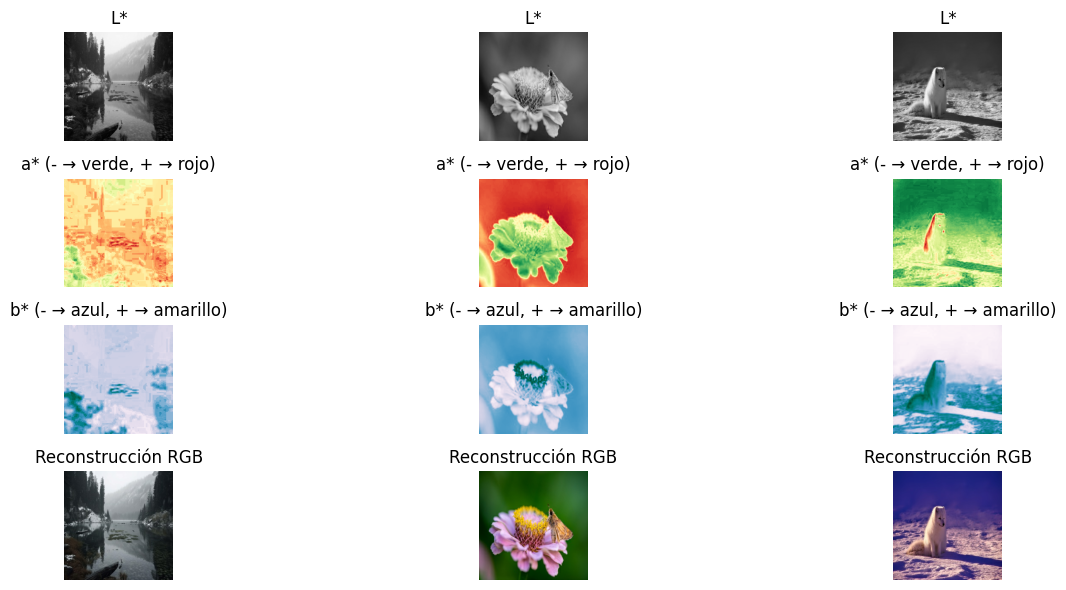

In [6]:
import matplotlib.pyplot as plt
import numpy as np

def show_sample_extended(ds, n=3):
    L_batch, ab_batch = next(iter(ds))
    plt.figure(figsize=(5*n, 6))
    for i in range(n):
        L   = L_batch[i].numpy()              # (256,256,1)
        ab  = ab_batch[i].numpy()             # (256,256,2)
        a   = ab[..., 0:1]
        b   = ab[..., 1:2]
        lab = np.concatenate([L, ab], axis=-1)

        gray = np.repeat((L+1)/2, 3, axis=-1)
        rgb  = lab_to_rgb(lab)

        # Filas: L / a / b / RGB
        plt.subplot(4, n, i+1);   plt.imshow(gray);          plt.axis("off"); plt.title("L*")
        plt.subplot(4, n, n+i+1); plt.imshow((a+1)/2, cmap='RdYlGn'); plt.axis("off"); plt.title("a* (‑ → verde, + → rojo)")
        plt.subplot(4, n, 2*n+i+1); plt.imshow((b+1)/2, cmap='PuBuGn'); plt.axis("off"); plt.title("b* (‑ → azul, + → amarillo)")
        plt.subplot(4, n, 3*n+i+1); plt.imshow(rgb);         plt.axis("off"); plt.title("Reconstrucción RGB")
    plt.tight_layout()

# Ejemplo rápido
show_sample_extended(train_ds, n=3)


# Fase 2 – Modelos: Generador U‑Net (ResNet‑18) y Discriminador PatchGAN 70×70

En esta parte vamos a construir **dos redes**:

| Rol | Arquitectura | Entrada | Salida | Comentarios |
|-----|--------------|---------|--------|-------------|
| **Generador G** | U‑Net = **encoder ResNet‑18 pre‑entrenado** + decoder simétrico con skip‑connections | L\* replicado a 3 canales (256×256×3) | mapa (256×256×2) con a\*, b\* en [‑1,1] | Replicamos L\* en los 3 canales para **aprovechar los pesos ImageNet** del encoder. |
| **Discriminador D** | **PatchGAN 70×70** (cadena Conv‑BN‑LeakyReLU) | Concatenación [L\*, a\*, b\*] (256×256×3) | mapa (30×30×1) de “real / fake” por parche | 70×70 receptive field ≈ 30×30 píxeles de salida cuando stride = 2. |

> Atajo visual <https://arxiv.org/abs/1611.07004> – sección 3.2 para los filtros PatchGAN.

**Pipeline de entrenamiento** (vistazo rápido, implementaremos en la siguiente fase):

1. G recibe **solo L\*** → produce (â\*,  b̂\*)  
2. Concatenamos L\* + [â\*,  b̂\*] y L\* + [a\*, b\*] reales → D los clasifica.  
3. Objetivos de loss:  
   * `L_adv = BCE(D(fake), 1)` vs `BCE(D(real), 1)`  
   * `L_L1 = λ · mean(|[â, b̂] – [a, b]|)`  
   * Total G = `L_adv + L_L1`,   D = `(L_real + L_fake)/2`.

---



In [10]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from keras_resnet import models as kr_models

In [18]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.applications import ResNet50

def build_generator(img_size=256):
    """
    Construye un generador estilo U-Net con un encoder basado en ResNet50.
    Entrada: imagen en escala de grises (L*) de tamaño img_size x img_size
    Salida: canales de color (a*, b*) de tamaño img_size x img_size
    """
    # 1. Input layer - canal L*
    input_L = Input(shape=(img_size, img_size, 1), name="input_L")

    # 2. Replicar el canal L* tres veces para simular RGB para ResNet
    x = layers.Concatenate()([input_L, input_L, input_L])

    # 3. Crear base ResNet50 (sin capas fully connected)
    base_model = ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(img_size, img_size, 3),
        pooling=None
    )

    # 4. Extraer capas para skip connections
    # ResNet50 tiene una estructura diferente a ResNet18, ajustamos los nombres
    skip_layer_names = [
        'conv1_relu',       # 128x128
        'conv2_block3_out', # 64x64
        'conv3_block4_out', # 32x32
        'conv4_block6_out'  # 16x16
    ]

    # 5. Congelar el backbone para aprovechar los pesos pre-entrenados
    base_model.trainable = False

    # 6. Obtener las salidas intermedias para skip connections
    skips = []
    for name in skip_layer_names:
        skips.append(base_model.get_layer(name).output)

    # 7. Extraer el bottleneck (última capa del encoder)
    bottleneck = base_model.output

    # 8. Aplicar ResNet a nuestra entrada
    encoder_outputs = base_model(x)

    # 9. Crear decoder con skip connections
    decoder_filters = [512, 256, 128, 64]

    # Comenzar con el bottleneck
    decoder = bottleneck

    # Añadir bloques de decodificación con skip connections
    for i, filters in enumerate(decoder_filters):
        decoder = layers.UpSampling2D(2)(decoder)

        # Añadir skip connection si está disponible
        if i < len(skips):
            skip = skips[-(i+1)]  # Usamos skip connections en orden inverso
            decoder = layers.Concatenate()([decoder, skip])

        # Capa conv después de la concatenación
        decoder = layers.Conv2D(filters, 3, padding='same', activation='relu')(decoder)
        decoder = layers.Conv2D(filters, 3, padding='same', activation='relu')(decoder)

    # Upsampling final para llegar a tamaño completo
    decoder = layers.UpSampling2D(2)(decoder)

    # Capa final de salida: 2 canales (a*, b*) con tanh para rango [-1, 1]
    output_ab = layers.Conv2D(2, 1, padding='same', activation='tanh')(decoder)

    # Construir el modelo completo
    model = Model(inputs=input_L, outputs=output_ab, name="Generator_UNet")

    return model

# Intentar crear el modelo
try:
    G = build_generator()
    print("Modelo creado exitosamente!")
    G.summary(line_length=110)
except Exception as e:
    print(f"Error al crear el modelo: {str(e)}")

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Modelo creado exitosamente!


Model: "Generator_UNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                   ┃ Output Shape              ┃          Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)     │ (None, 256, 256, 3)       │                0 │ -                          │
├────────────────────────────────┼───────────────────────────┼──────────────────┼────────────────────────────┤
│ conv1_pad (ZeroPadding2D)      │ (None, 262, 262, 3)       │                0 │ input_layer_2[0][0]        │
├────────────────────────────────┼───────────────────────────┼──────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)            │ (None, 128, 128, 64)      │            9,472 │ conv1_pad[0][0]            │
├────────────────────────────────┼───────────────────────────┼──────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization)  │ (None, 128, 128, 64)      │              256 │ conv1_conv[0][0]           │
├────────────────────────────────┼───────────────────────────┼──────────────────┼────────────────────────────┤
│ conv1_relu (Activation)        │ (None, 128, 128, 64)      │                0 │ conv1_bn[0][0]             │
├────────────────────────────────┼───────────────────────────┼──────────────────┼────────────────────────────┤
│ pool1_pad (ZeroPadding2D)      │ (None, 130, 130, 64)      │                0 │ conv1_relu[0][0]           │
├────────────────────────────────┼───────────────────────────┼──────────────────┼────────────────────────────┤
│ pool1_pool (MaxPooling2D)      │ (None, 64, 64, 64)        │                0 │ pool1_pad[0][0]            │
├────────────────────────────────┼───────────────────────────┼──────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)   │ (None, 64, 64, 64)        │            4,160 │ pool1_pool[0][0]           │
├────────────────────────────────┼───────────────────────────┼──────────────────┼────────────────────────────┤
│ conv2_block1_1_bn              │ (None, 64, 64, 64)        │              256 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)           │                           │                  │                            │
├────────────────────────────────┼───────────────────────────┼──────────────────┼────────────────────────────┤
│ conv2_block1_1_relu            │ (None, 64, 64, 64)        │                0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                   │                           │                  │                            │
├────────────────────────────────┼───────────────────────────┼──────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)   │ (None, 64, 64, 64)        │           36,928 │ conv2_block1_1_relu[0][0]  │
├────────────────────────────────┼───────────────────────────┼──────────────────┼────────────────────────────┤
│ conv2_block1_2_bn              │ (None, 64, 64, 64)        │              256 │ conv2_block1_2_conv[0][0]  │
│ (BatchNormalization)           │                           │                  │                            │
├────────────────────────────────┼───────────────────────────┼──────────────────┼────────────────────────────┤
│ conv2_block1_2_relu            │ (None, 64, 64, 64)        │                0 │ conv2_block1_2_bn[0][0]    │
│ (Activation)                   │                           │                  │                            │
├────────────────────────────────┼───────────────────────────┼──────────────────┼────────────────────────────┤
│ conv2_block1_0_conv (Conv2D)   │ (None, 64, 64, 256)       │           16,640 │ pool1_pool[0][0]           │
├────────────────────────────────┼───────────────────────────┼──────────────────┼────────────────────────────┤
│ conv2_block1_3_conv (Conv2D)   │ (None, 64, 64, 256)       │           16,640 │ conv2_block1_2_relu[0][0]  │
├───

 Total params: 43,938,690 (167.61 MB)

 Trainable params: 20,350,978 (77.63 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

# Fase 2.2 – Definición del Discriminador PatchGAN

En esta celda vamos a:

1. Definir la función `build_discriminator()` para crear un **PatchGAN 70×70**, que evalúe la coherencia local del color.  
2. Instanciar el modelo `D` y mostrar su arquitectura con `D.summary()`.  

El discriminador recibirá dos tensores:
- **L\***: canal de luminosidad (H×W×1)  
- **ab**: canales de crominancia (H×W×2)  

y devolverá un mapa de “real vs fake” de tamaño aproximado 30×30×1.


In [19]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Input

def build_discriminator(img_size=256):
    """
    Construye un discriminador PatchGAN 70×70.
    Entrada: L* (1 canal) + ab (2 canales)
    Salida: mapa (≈30×30×1) de real vs fake
    """
    # 1) Definir entradas
    inp_L  = Input(shape=(img_size, img_size, 1), name="L_input")
    inp_ab = Input(shape=(img_size, img_size, 2), name="ab_input")

    # 2) Concatenar canales para formar un tensor H×W×3
    x = layers.Concatenate()([inp_L, inp_ab])

    # 3) Bloque inicial (sin BatchNorm)
    nf = 64
    x = layers.Conv2D(nf, kernel_size=4, strides=2, padding="same")(x)
    x = layers.LeakyReLU(0.2)(x)

    # 4) Bloques intermedios con BatchNorm
    for i in range(1, 4):
        nf = min(nf * 2, 512)
        x = layers.Conv2D(nf, kernel_size=4, strides=2, padding="same", use_bias=False)(x)
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU(0.2)(x)

    # 5) Capa final genera el mapa de parches
    x = layers.Conv2D(1, kernel_size=4, padding="same", name="patch_logits")(x)

    return Model(inputs=[inp_L, inp_ab], outputs=x, name="Discriminator_PatchGAN")

# Instanciar y mostrar resumen
D = build_discriminator()
print("Discriminador creado exitosamente!")
D.summary(line_length=110)


Discriminador creado exitosamente!


Model: "Discriminator_PatchGAN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                   ┃ Output Shape              ┃          Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ L_input (InputLayer)           │ (None, 256, 256, 1)       │                0 │ -                          │
├────────────────────────────────┼───────────────────────────┼──────────────────┼────────────────────────────┤
│ ab_input (InputLayer)          │ (None, 256, 256, 2)       │                0 │ -                          │
├────────────────────────────────┼───────────────────────────┼──────────────────┼────────────────────────────┤
│ concatenate_13 (Concatenate)   │ (None, 256, 256, 3)       │                0 │ L_input[0][0],             │
│                                │                           │                  │ ab_input[0][0]             │
├────────────────────────────────┼───────────────────────────┼──────────────────┼────────────────────────────┤
│ conv2d_9 (Conv2D)              │ (None, 128, 128, 64)      │            3,136 │ concatenate_13[0][0]       │
├────────────────────────────────┼───────────────────────────┼──────────────────┼────────────────────────────┤
│ leaky_re_lu (LeakyReLU)        │ (None, 128, 128, 64)      │                0 │ conv2d_9[0][0]             │
├────────────────────────────────┼───────────────────────────┼──────────────────┼────────────────────────────┤
│ conv2d_10 (Conv2D)             │ (None, 64, 64, 128)       │          131,072 │ leaky_re_lu[0][0]          │
├────────────────────────────────┼───────────────────────────┼──────────────────┼────────────────────────────┤
│ batch_normalization            │ (None, 64, 64, 128)       │              512 │ conv2d_10[0][0]            │
│ (BatchNormalization)           │                           │                  │                            │
├────────────────────────────────┼───────────────────────────┼──────────────────┼────────────────────────────┤
│ leaky_re_lu_1 (LeakyReLU)      │ (None, 64, 64, 128)       │                0 │ batch_normalization[0][0]  │
├────────────────────────────────┼───────────────────────────┼──────────────────┼────────────────────────────┤
│ conv2d_11 (Conv2D)             │ (None, 32, 32, 256)       │          524,288 │ leaky_re_lu_1[0][0]        │
├────────────────────────────────┼───────────────────────────┼──────────────────┼────────────────────────────┤
│ batch_normalization_1          │ (None, 32, 32, 256)       │            1,024 │ conv2d_11[0][0]            │
│ (BatchNormalization)           │                           │                  │                            │
├────────────────────────────────┼───────────────────────────┼──────────────────┼────────────────────────────┤
│ leaky_re_lu_2 (LeakyReLU)      │ (None, 32, 32, 256)       │                0 │ batch_normalization_1[0][… │
├────────────────────────────────┼───────────────────────────┼──────────────────┼────────────────────────────┤
│ conv2d_12 (Conv2D)             │ (None, 16, 16, 512)       │        2,097,152 │ leaky_re_lu_2[0][0]        │
├────────────────────────────────┼───────────────────────────┼──────────────────┼────────────────────────────┤
│ batch_normalization_2          │ (None, 16, 16, 512)       │            2,048 │ conv2d_12[0][0]            │
│ (BatchNormalization)           │                           │                  │                            │
├────────────────────────────────┼───────────────────────────┼──────────────────┼────────────────────────────┤
│ leaky_re_lu_3 (LeakyReLU)      │ (None, 16, 16, 512)       │                0 │ batch_normalization_2[0][… │
├────────────────────────────────┼───────────────────────────┼──────────────────┼────────────────────────────┤
│ patch_logits (Conv2D)          │ (None, 16, 16, 1)         │            8,193 │ leaky_re_lu_3[0][0]        │
└───

 Total params: 2,767,425 (10.56 MB)

 Trainable params: 2,765,633 (10.55 MB)

 Non-trainable params: 1,792 (7.00 KB)

# Pérdidas, métricas y bucle de entrenamiento

En este bloque vamos a:

1. Instalar e inicializar **Weights & Biases** para trackear el experimento.  
2. Definir las funciones de **pérdida**:
   - **GAN loss** (BinaryCrossentropy sobre logits)  
   - **L1 loss** para crominancia (a\*/b\*) con λ = 100  
3. Crear las **métricas perceptuales**:
   - **PSNR** y **SSIM** (en espacio RGB reconstruido)  
4. Implementar los pasos de **entrenamiento** (`train_step`) y **validación** (`val_step`) con `tf.GradientTape`.  
5. Montar el **bucle principal** que:
   - Recorre train / val por épocas.  
   - Actualiza G y D.  
   - Registra pérdidas y métricas a W&B.  
   - Imprime un resumen de cada época.


In [24]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Input, optimizers
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import wandb
import os
import time
from IPython.display import clear_output
import gradio as gr

# Configuración general
EPOCHS = 100        # Número de épocas para entrenar
LAMBDA_L1 = 100    # Peso para el término de pérdida L1 en el generador
LEARNING_RATE_G = 2e-4  # Tasa de aprendizaje para el generador
LEARNING_RATE_D = 2e-4  # Tasa de aprendizaje para el discriminador
SAVE_FREQ = 5      # Cada cuántas épocas guardar el modelo

# Asegurarnos que los modelos G y D estén definidos (ya se crearon anteriormente)
# G = build_generator()
# D = build_discriminador()

# Definir optimizadores
optimizer_g = optimizers.Adam(learning_rate=LEARNING_RATE_G, beta_1=0.5)
optimizer_d = optimizers.Adam(learning_rate=LEARNING_RATE_D, beta_1=0.5)

# Funciones de pérdida
loss_bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
loss_l1 = tf.keras.losses.MeanAbsoluteError()

# Función de pérdida del discriminador
def discriminator_loss(real_output, fake_output):
    # Etiquetas suavizadas para estabilizar el entrenamiento
    real_labels = tf.ones_like(real_output) * 0.9  # Suavizado de etiquetas
    fake_labels = tf.zeros_like(fake_output)

    # Pérdida para imágenes reales
    real_loss = loss_bce(real_labels, real_output)
    # Pérdida para imágenes falsas
    fake_loss = loss_bce(fake_labels, fake_output)

    # Pérdida total
    total_loss = (real_loss + fake_loss) * 0.5
    return total_loss

# Función de pérdida del generador
def generator_loss(fake_output, ab_true, ab_pred):
    # Pérdida adversarial (queremos que el discriminador clasifique las imágenes generadas como reales)
    adversarial_loss = loss_bce(tf.ones_like(fake_output), fake_output)

    # Pérdida L1 (diferencia entre los colores reales y predichos)
    l1_loss = loss_l1(ab_true, ab_pred) * LAMBDA_L1

    # Pérdida total
    total_loss = adversarial_loss + l1_loss
    return total_loss, adversarial_loss, l1_loss

# Métricas perceptuales
def compute_metrics(l_true, ab_true, ab_pred):
    # Reconstruir imágenes RGB a partir de L*a*b*
    batch_size = tf.shape(l_true)[0]
    metrics = {"psnr": 0.0, "ssim": 0.0}

    # Convertir de tensor a numpy para usar las funciones de skimage
    l_true_np = l_true.numpy()
    ab_true_np = ab_true.numpy()
    ab_pred_np = ab_pred.numpy()

    # Para cada imagen en el batch
    for i in range(batch_size):
        # Concatenar L* con a*b* (reales y predichos)
        lab_true = np.concatenate([l_true_np[i], ab_true_np[i]], axis=-1)
        lab_pred = np.concatenate([l_true_np[i], ab_pred_np[i]], axis=-1)

        # Convertir de L*a*b* a RGB
        rgb_true = lab_to_rgb(lab_true)
        rgb_pred = lab_to_rgb(lab_pred)

        # Calcular métricas
        metrics["psnr"] += psnr(rgb_true, rgb_pred)
        metrics["ssim"] += ssim(rgb_true, rgb_pred, channel_axis=2, data_range=1.0)

    # Promediar métricas por batch
    metrics["psnr"] /= batch_size
    metrics["ssim"] /= batch_size

    return metrics

In [25]:
# Función de entrenamiento por pasos (usando tf.GradientTape)
@tf.function
def train_step(l_images, ab_images):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Generar colores falsos a partir de la luminancia
        ab_generated = G(l_images, training=True)

        # Obtener predicciones del discriminador para colores reales y falsos
        disc_real_output = D([l_images, ab_images], training=True)
        disc_fake_output = D([l_images, ab_generated], training=True)

        # Calcular pérdidas
        gen_total_loss, gen_adv_loss, gen_l1_loss = generator_loss(
            disc_fake_output, ab_images, ab_generated)
        disc_loss = discriminator_loss(disc_real_output, disc_fake_output)

    # Calcular gradientes
    gen_gradients = gen_tape.gradient(gen_total_loss, G.trainable_variables)
    disc_gradients = disc_tape.gradient(disc_loss, D.trainable_variables)

    # Aplicar gradientes
    optimizer_g.apply_gradients(zip(gen_gradients, G.trainable_variables))
    optimizer_d.apply_gradients(zip(disc_gradients, D.trainable_variables))

    return {
        "g_total_loss": gen_total_loss,
        "g_adv_loss": gen_adv_loss,
        "g_l1_loss": gen_l1_loss,
        "d_loss": disc_loss
    }


In [26]:
# Función de validación por pasos
def val_step(l_images, ab_images):
    # Generar colores falsos sin calcular gradientes
    ab_generated = G(l_images, training=False)

    # Obtener predicciones del discriminador
    disc_real_output = D([l_images, ab_images], training=False)
    disc_fake_output = D([l_images, ab_generated], training=False)

    # Calcular pérdidas
    gen_total_loss, gen_adv_loss, gen_l1_loss = generator_loss(
        disc_fake_output, ab_images, ab_generated)
    disc_loss = discriminator_loss(disc_real_output, disc_fake_output)

    # Calcular métricas perceptuales
    metrics = compute_metrics(l_images, ab_images, ab_generated)

    return {
        "g_total_loss": gen_total_loss,
        "g_adv_loss": gen_adv_loss,
        "g_l1_loss": gen_l1_loss,
        "d_loss": disc_loss,
        "psnr": metrics["psnr"],
        "ssim": metrics["ssim"],
        "sample_images": (l_images[:4], ab_images[:4], ab_generated[:4])  # Guardar muestras para visualización
    }

In [23]:
# Función para mostrar y guardar resultados
def display_results(l_images, ab_true, ab_pred, epoch, batch=0, save=True):
    plt.figure(figsize=(15, 10))

    # Mostrar imágenes
    for i in range(min(4, l_images.shape[0])):
        # Imagen en escala de grises (solo L*)
        gray_image = np.repeat((l_images[i] + 1) / 2, 3, axis=-1)

        # Imagen original (L* + a*b* reales)
        lab_true = np.concatenate([l_images[i], ab_true[i]], axis=-1)
        rgb_true = lab_to_rgb(lab_true)

        # Imagen generada (L* + a*b* predichos)
        lab_pred = np.concatenate([l_images[i], ab_pred[i]], axis=-1)
        rgb_pred = lab_to_rgb(lab_pred)

        # Mostrar las tres imágenes en una fila
        plt.subplot(4, 3, i*3 + 1)
        plt.imshow(gray_image)
        plt.title("Entrada (L*)")
        plt.axis("off")

        plt.subplot(4, 3, i*3 + 2)
        plt.imshow(rgb_true)
        plt.title("Original")
        plt.axis("off")

        plt.subplot(4, 3, i*3 + 3)
        plt.imshow(rgb_pred)
        plt.title("Generada")
        plt.axis("off")

    plt.tight_layout()

    if save:
        plt.savefig(f"results/epoch_{epoch}_batch_{batch}.png")
        # También guardar en wandb
        wandb.log({"samples": wandb.Image(plt)}, step=epoch)

    plt.show()
    plt.close()

# Directorio para guardar modelos y resultados
os.makedirs("models", exist_ok=True)
os.makedirs("results", exist_ok=True)

# Inicializar W&B con la configuración del experimento
wandb.init(
    project="GANs",
    entity="arturo-torres-iteso",
    name=f"colorization_gan_{time.strftime('%Y%m%d-%H%M')}",
    config={
        "architecture": "UNet-ResNet50 + PatchGAN",
        "dataset_size": len(train_files) + len(val_files),
        "batch_size": BATCH_SIZE,
        "learning_rate_g": LEARNING_RATE_G,
        "learning_rate_d": LEARNING_RATE_D,
        "lambda_l1": LAMBDA_L1,
        "epochs": EPOCHS,
        "img_size": IMG_SIZE
    }
)


In [ ]:
# Bucle principal de entrenamiento
def train():
    for epoch in range(EPOCHS):
        start = time.time()
        print(f"Epoch {epoch+1}/{EPOCHS}")

        # Variables para acumular pérdidas
        train_losses = {"g_total_loss": 0, "g_adv_loss": 0, "g_l1_loss": 0, "d_loss": 0}
        val_losses = {"g_total_loss": 0, "g_adv_loss": 0, "g_l1_loss": 0, "d_loss": 0, "psnr": 0, "ssim": 0}

        # Entrenamiento
        for batch_idx, (l_batch, ab_batch) in enumerate(train_ds):
            # Paso de entrenamiento
            batch_losses = train_step(l_batch, ab_batch)

            # Acumular pérdidas
            for k in train_losses:
                train_losses[k] += batch_losses[k]

            # Mostrar progreso
            if batch_idx % 10 == 0:
                print(f"  Batch {batch_idx}/{len(train_ds)}, "
                      f"G_loss: {batch_losses['g_total_loss']:.4f}, "
                      f"D_loss: {batch_losses['d_loss']:.4f}")

        # Calcular promedios de pérdidas de entrenamiento
        for k in train_losses:
            train_losses[k] /= len(train_ds)

        # Validación
        for batch_idx, (l_batch, ab_batch) in enumerate(val_ds):
            # Paso de validación
            batch_val = val_step(l_batch, ab_batch)

            # Acumular pérdidas y métricas
            for k in val_losses:
                val_losses[k] += batch_val[k] if k != "sample_images" else 0

            # Guardar los últimos resultados para visualización
            if batch_idx == len(val_ds) - 1:
                val_samples = batch_val["sample_images"]

        # Calcular promedios de pérdidas y métricas de validación
        for k in val_losses:
            val_losses[k] /= len(val_ds)

        # Mostrar resultados de la época
        clear_output(wait=True)
        print(f"Tiempo por época: {time.time() - start:.2f} seg")
        print(f"Entrenamiento - G_loss: {train_losses['g_total_loss']:.4f}, D_loss: {train_losses['d_loss']:.4f}")
        print(f"Validación   - G_loss: {val_losses['g_total_loss']:.4f}, D_loss: {val_losses['d_loss']:.4f}")
        print(f"Métricas     - PSNR: {val_losses['psnr']:.2f} dB, SSIM: {val_losses['ssim']:.4f}")

        # Visualizar algunos resultados
        l_samples, ab_true_samples, ab_pred_samples = val_samples
        display_results(l_samples, ab_true_samples, ab_pred_samples, epoch+1)

        # Guardar modelos cada cierta cantidad de épocas
        if (epoch + 1) % SAVE_FREQ == 0:
            G.save(f"models/generator_epoch_{epoch+1}.h5")
            D.save(f"models/discriminator_epoch_{epoch+1}.h5")

        # Registrar métricas en W&B
        wandb.log({
            "epoch": epoch + 1,
            "train/g_total_loss": train_losses["g_total_loss"],
            "train/g_adv_loss": train_losses["g_adv_loss"],
            "train/g_l1_loss": train_losses["g_l1_loss"],
            "train/d_loss": train_losses["d_loss"],
            "val/g_total_loss": val_losses["g_total_loss"],
            "val/g_adv_loss": val_losses["g_adv_loss"],
            "val/g_l1_loss": val_losses["g_l1_loss"],
            "val/d_loss": val_losses["d_loss"],
            "val/psnr": val_losses["psnr"],
            "val/ssim": val_losses["ssim"]
        })

    # Guardar modelos finales
    G.save("models/generator_final.h5")
    D.save("models/discriminator_final.h5")

    # Finalizar W&B
    wandb.finish()

# Ejecutar entrenamiento
if __name__ == "__main__":
    train()